<a href="https://colab.research.google.com/github/diggs1711/comma-ai-speed-challenge/blob/master/speed_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline
from cv2 import VideoCapture, namedWindow, WINDOW_AUTOSIZE, waitKey
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from pathlib import Path
drive_path = Path('/content/drive/My Drive/comma_ai_speed_challenge/speedchallenge-master/data/')

In [0]:
train_vals = np.array(pd.read_fwf(drive_path/'train.txt', header=None))

In [28]:
print(f"mean {train_vals.mean()}")
print(f"max {train_vals.max()}")
print(f"std {train_vals.std()}")
print(f"min {train_vals.min()}")

idx = int(len(train_vals) / 2)
print()
print("*** First half of video ****")
first_half = train_vals[:idx]
print(f"mean 1st {first_half.mean()}")
print(f"max 1st {first_half.max()}")
print(f"std 1st {first_half.std()}")
print(f"min 1st {first_half.min()}")

print()
print("*** Second half of video ****")
second_half = train_vals[idx:]
print(f"mean 2nd {second_half.mean()}")
print(f"max 2nd {second_half.max()}")
print(f"std 2nd {second_half.std()}")
print(f"min 2nd {second_half.min()}")

mean 12.183181660441177
max 28.130404
std 8.206561706745727
min 0.0

*** First half of video ****
mean 1st 18.66717958362745
max 1st 28.130404
std 1st 5.883530076403356
min 1st 0.0

*** Second half of video ****
mean 2nd 5.699183737254902
max 2nd 14.890168
std 2nd 3.9993656743963695
min 2nd 0.0


In [0]:
numberOfFrame = 20400
fps = 20
cropped_image_height = 100
cropped_image_width = 440

In [0]:
# load video frame by frame
cap = VideoCapture(str(drive_path/'train.mp4'))
i = 0
video_frames = []

while i < numberOfFrame:
  ret_val, frame = cap.read()
  cropped_image = frame[200:200+cropped_image_height,100:100+cropped_image_width, 2]
  video_frames.append(np.array(cropped_image))
  i = i + 1

cap.release()

In [0]:
video_frames = np.array(video_frames)

In [0]:
np.save(str(drive_path/'video_frames'), video_frames)

In [0]:
video_frames = np.load(str(drive_path/'video_frames.npy'))

In [7]:
video_frames.shape

(20400, 100, 440)

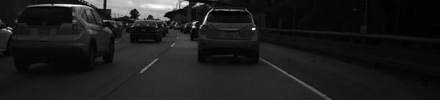

In [8]:
cv2_imshow(video_frames[10000,:,:])

In [0]:
# create train and validation sets
import math
valid_idx =  math.floor(numberOfFrame * 0.8)
reduce_idx = 10000
X_train = video_frames[reduce_idx:valid_idx][np.newaxis, ..., np.newaxis]
y_train = train_vals[reduce_idx:valid_idx][np.newaxis]

X_valid = video_frames[valid_idx:][np.newaxis, ..., np.newaxis]
y_valid = train_vals[valid_idx:][np.newaxis]

In [0]:
# normalize values between 0 and 1
X_train = X_train / 255
X_valid = X_valid / 255

In [11]:
X_valid.shape

(1, 4080, 100, 440, 1)

In [12]:
import gc

del video_frames, train_vals;

gc.collect()

68

In [0]:
from keras.layers import Dense, Flatten
from keras.layers import ConvLSTM2D, TimeDistributed
from keras.models import Sequential
import keras

model=Sequential()
model.add(
    ConvLSTM2D(
        2,
        (5, 5),
        strides=3, 
        padding='same',
        return_sequences=True,
        input_shape=(None, X_train.shape[2], X_train.shape[3], X_train.shape[4])
        )
    )
model.add(TimeDistributed(Flatten()))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer=keras.optimizers.Adam(), metrics=['mse'])

model.summary()
model.fit(
    X_train,
    y_train,
    batch_size=1,
    epochs=100, 
    validation_data=(X_valid, y_valid)
    )

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_3 (ConvLSTM2D)  (None, None, 34, 147, 2)  608       
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 9996)        0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 1)           9997      
Total params: 10,605
Trainable params: 10,605
Non-trainable params: 0
_________________________________________________________________
Train on 1 samples, validate on 1 samples
Epoch 1/100
1/1 [==============================] - 40s 40s/step - loss: 50.2632 - mse: 50.2632 - val_loss: 45.3604 - val_mse: 45.3604
Epoch 2/100
1/1 [==============================] - 38s 38s/step - loss: 47.9855 - mse: 47.9855 - val_loss: 41.8007 - val_mse: 41.8007
Epoch 3/100
1/1 [==============================] - 38s 38s/step - loss